In [173]:
import torch
import torch.nn as nn
import numpy as np
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F
import copy
%matplotlib inline

In [221]:
size = 5
sigma = 20

In [222]:
# Define the image transformations
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flip with a probability of 0.5
    transforms.ColorJitter(saturation=(0.95, 1.05), brightness=0.05, contrast=(0.95, 1.05)),  # Random saturation, brightness, and contrast
    transforms.RandomApply([
        transforms.RandomCrop(144, pad_if_needed=True),  # Random crop of (crop_size + 2*wiggle)
        transforms.Resize((128, 128))  # Resize to crop_size x crop_size
    ], p=1.0),  # Ensure this transformation is always applied
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize image to [0,1] range
])

In [223]:
def _fspecial_gauss(size, sigma):
    """Function to mimic the 'fspecial' gaussian MATLAB function"""
    x = torch.arange(-size//2 + 1., size//2 + 1.)
    x = x.reshape(1, -1)
    y = x.t()
    x0 = x.shape[1] // 2
    y0 = y.shape[0] // 2
    g = torch.exp(-0.5 * ((x - x0)**2 + (y - y0)**2) / sigma**2)
    return g / g.sum()

In [224]:
def blur(image, size, sigma):
    kernel = _fspecial_gauss(size, sigma).unsqueeze(0).unsqueeze(0)
    
    r = F.conv2d(image[:, 0, :, :].unsqueeze(1), kernel, padding='same')
    g = F.conv2d(image[:, 1, :, :].unsqueeze(1), kernel, padding='same')
    b = F.conv2d(image[:, 2, :, :].unsqueeze(1), kernel, padding='same')

    convolved = torch.cat([r, g, b], dim=1)
    return convolved

In [227]:
def gaussian_noise(image, noise_level):
    return image + torch.randn(image.size()) * noise_level

In [229]:
def show_2_images(image1, image2):
    f, axarr = plt.subplots(2)
    axarr[0].imshow(image1.permute(1, 2, 0))
    axarr[1].imshow(image2.permute(1, 2, 0))

In [242]:
def read_images(filenames):
    images = []
    for filename in filenames:
        image = Image.open(filename).convert('RGB')  # Open and convert the image to RGB
        image = transform(image)  # Apply the transformations
        image = image.reshape(1, 3, 128, 128)
        # add blur // gaussian noise here
        # image_blur = blur(image, size, sigma)
        # image_gaussian = gaussian_noise(image, 0.1)
        images.append(image)
    return torch.stack(images)  # Stack images into a single tensor


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


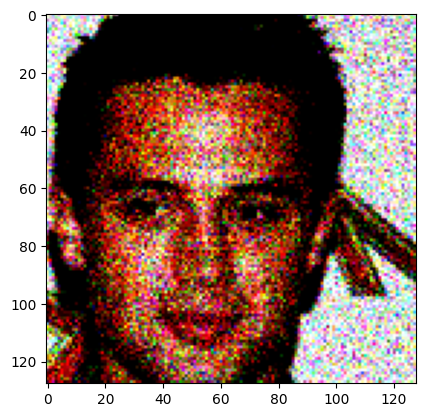

In [243]:
imgs = ['./celeb/000007.jpg']
tens_stack = read_images(filenames=imgs)